# Data Munging

**Kenneth Liao**
<br>**3/6/2019**

Data preparation is an essential first step in building any type of analytical or predictive model. This notebook presents the data cleaning steps taken on the "Practice Problem Recommendation Engine" data from Analytics Vidhya.

Original data source: https://datahack.analyticsvidhya.com/contest/practice-problem-recommendation-engine/

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Load the submission, user, and problem datasets
train_submission = pd.read_csv('data/train_submissions.csv')
problem_data = pd.read_csv('data/problem_data.csv')
user_data = pd.read_csv('data/user_data.csv')

## Train Submissions

My goal for this project is to start with a logistic regression model as my baseline and then compare the performance to a collaborative filtering model of increasing complexity.

Collaborative filtering models that employ matrix factorization techniques are widely popular due to their scalability and ability to work on highly sparse data sets. Regression models on the otherhand typically require dense matrices as input. I will therefore focus my data munging on feature generation and imputing missing data for the regression model.

I'll start by looking for missing data in the train_submission dataset which simply contains the 3 columns shown below

In [3]:
train_submission.head(10)

user_id problem_id  attempts_range
0   user_232  prob_6507               1
1  user_3568  prob_2994               3
2  user_1600  prob_5071               1
3  user_2256   prob_703               1
4  user_2321   prob_356               1
5  user_1569  prob_6064               1
6  user_3293  prob_1237               1
7   user_915  prob_4125               2
8  user_2032  prob_1943               1
9  user_1410  prob_3935               1

The attempts range is defined on the original data source website as:
    
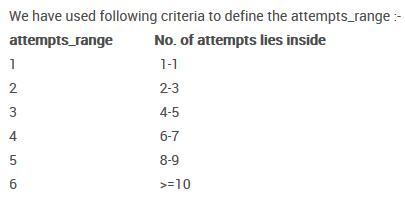

Which means I actually don't know the exact number of attempts a user required to solve a particular problem, only which of the specified bins the number of attempts falls into.

Using the .info() method, I see each column contains the same number of non-null values as the length of the index, therefore this dataset contains no null values. That's nice.

In [4]:
train_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155295 entries, 0 to 155294
Data columns (total 3 columns):
user_id           155295 non-null object
problem_id        155295 non-null object
attempts_range    155295 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


## User Data

Next, I'll check the user_data dataset for null values.

In [5]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 11 columns):
user_id                      3571 non-null object
submission_count             3571 non-null int64
problem_solved               3571 non-null int64
contribution                 3571 non-null int64
country                      2418 non-null object
follower_count               3571 non-null int64
last_online_time_seconds     3571 non-null int64
max_rating                   3571 non-null float64
rating                       3571 non-null float64
rank                         3571 non-null object
registration_time_seconds    3571 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 307.0+ KB


The user_data dataset contains over a thousand null values in the 'country' column. I'll pull the user data for only users with a missing country column and inspect this subset. The columns are described as follows:



In [6]:
user_data[user_data.country.isnull()].head(10)

user_id  submission_count  problem_solved  contribution country  \
0   user_3311                47              40             0     NaN   
5   user_3177                 3               1             0     NaN   
7   user_3306                 2               1             0     NaN   
8   user_1483                91              79             0     NaN   
9    user_667                91              71             0     NaN   
18  user_1258               422             384            -1     NaN   
19  user_1122               145             118             0     NaN   
21  user_2377                 7               6             0     NaN   
23  user_2450                55              49             0     NaN   
28   user_564               250             223            -1     NaN   

    follower_count  last_online_time_seconds  max_rating   rating  \
0                4                1504111645     348.337  330.849   
5                0                1484244659     331.135  331.135   
7                0                1505568051     304.186  281.250   
8                0                1502437836     318.807  258.888   
9                4                1494953565     383.028  362.959   
18              25                1505283301     352.638  263.475   
19               3                1500401774     313.073  261.468   
21               0                1484753545     360.092  327.122   
23               8                1501516127     428.899  382.741   
28              25                1504619817     411.124  401.950   

            rank  registration_time_seconds  
0   intermediate                 1466686436  
5   intermediate                 1484233893  
7       beginner                 1484233261  
8       beginner                 1472711718  
9   intermediate                 1403610149  
18      beginner                 1472893364  
19      beginner                 1439017942  
21  intermediate                 1480937199  
23  intermediate                 1455099543  
28  intermediate                 1432050748

Is it possible that these users have duplicate entries, and perhaps the country is stored in the other duplicate rows? I can quickly check this by ensuring that all user_ids are unique.

In [7]:
print('Are all user_ids unique? %s' % (user_data.user_id.nunique() == len(user_data)))

Are all user_ids unique? True


So all user_ids are unique and I won't be able to pull the missing country information from duplicate values. To apply a regression model to this data set, any samples with missing data would have to be ignored. This list-wise deletion of samples could cause us to lose a lot of valuable data since over 1000 out of the 3571 unique users don't have a corresponding country value.

Since there is no way of extracting what country each user belongs to from the available data, I can fill all missing values with the string 'None'. This will allow me to group all of these users into a single country value, and not sacrifice any samples.

In [8]:
user_data = user_data.fillna('None')
user_data.head(10)

user_id  submission_count  problem_solved  contribution  country  \
0  user_3311                47              40             0     None   
1  user_3028                63              52             0    India   
2  user_2268               226             203            -8    Egypt   
3   user_480               611             490             1  Ukraine   
4   user_650               504             479            12   Russia   
5  user_3177                 3               1             0     None   
6  user_2032               216             199             0    India   
7  user_3306                 2               1             0     None   
8  user_1483                91              79             0     None   
9   user_667                91              71             0     None   

   follower_count  last_online_time_seconds  max_rating   rating  \
0               4                1504111645     348.337  330.849   
1              17                1498998165     405.677  339.450   
2              24                1505566052     307.339  284.404   
3              94                1505257499     525.803  471.330   
4               4                1496613433     548.739  486.525   
5               0                1484244659     331.135  331.135   
6              28                1505534677     387.328  387.328   
7               0                1505568051     304.186  281.250   
8               0                1502437836     318.807  258.888   
9               4                1494953565     383.028  362.959   

           rank  registration_time_seconds  
0  intermediate                 1466686436  
1  intermediate                 1441893325  
2      beginner                 1454267603  
3      advanced                 1350720417  
4      advanced                 1395560498  
5  intermediate                 1484233893  
6  intermediate                 1443374825  
7      beginner                 1484233261  
8      beginner                 1472711718  
9  intermediate                 1403610149

The user_data is now ready. There are addtional steps that will have to be applied to the data before feeding it into a model. For example, I'll have to convert any categorical variables into dummy variables so that I have only numeric data types. I will show how I can achieve this below, but will leave the categorical variables for now to make it easier to interpret results in the exploratory analysis mini project.

In [9]:
user_data.country.unique()

array(['None', 'India', 'Egypt', 'Ukraine', 'Russia', 'China',
       'Indonesia', 'Syria', 'Poland', 'Vietnam', 'Japan', 'Colombia',
       'Singapore', 'Bangladesh', 'Brazil', 'Thailand', 'South Korea',
       'Tajikistan', 'Croatia', 'Italy', 'Turkmenistan', 'Cuba', 'Taiwan',
       'Iran', 'Kazakhstan', 'Georgia', 'Bolivia', 'Belarus', 'Germany',
       'Estonia', 'United States', 'Canada', 'Moldova', 'Mongolia',
       'Tunisia', 'Armenia', 'Argentina', 'Uzbekistan', 'Kyrgyzstan',
       'Romania', 'North Korea', 'Hong Kong', 'Jordan', 'Austria',
       'Serbia', 'Peru', 'Finland', 'Switzerland', 'South Africa',
       'Mexico', 'Costa Rica', 'Israel', 'Belgium', 'United Kingdom',
       'Spain', 'Netherlands', 'Slovakia', 'Czechia', 'Azerbaijan',
       'Norway', 'Australia', 'Bosnia and Herzegovina', 'Malaysia',
       'Philippines', 'Macedonia', 'Lithuania', 'Bulgaria', 'Morocco',
       'Hungary', 'Chile', 'Venezuela', 'Haiti', 'Iceland',
       'Trinidad and Tobago', 'France'

In [10]:
country_mapping = {v: i for i, v in enumerate(user_data.country.unique())}
country_mapping

{'Argentina': 36,
 'Armenia': 35,
 'Australia': 60,
 'Austria': 43,
 'Azerbaijan': 58,
 'Bangladesh': 13,
 'Belarus': 27,
 'Belgium': 52,
 'Bolivia': 26,
 'Bosnia and Herzegovina': 61,
 'Brazil': 14,
 'Bulgaria': 66,
 'Canada': 31,
 'Chile': 69,
 'China': 5,
 'Christmas Island': 75,
 'Colombia': 11,
 'Costa Rica': 50,
 'Croatia': 18,
 'Cuba': 21,
 'Czechia': 57,
 'Egypt': 2,
 'Estonia': 29,
 'Finland': 46,
 'France': 74,
 'Georgia': 25,
 'Germany': 28,
 'Haiti': 71,
 'Hong Kong': 41,
 'Hungary': 68,
 'Iceland': 72,
 'India': 1,
 'Indonesia': 6,
 'Iran': 23,
 'Israel': 51,
 'Italy': 19,
 'Japan': 10,
 'Jordan': 42,
 'Kazakhstan': 24,
 'Kyrgyzstan': 38,
 'Laos': 77,
 'Latvia': 78,
 'Lebanon': 79,
 'Lithuania': 65,
 'Macedonia': 64,
 'Malaysia': 62,
 'Mexico': 49,
 'Moldova': 32,
 'Mongolia': 33,
 'Morocco': 67,
 'Netherlands': 55,
 'None': 0,
 'North Korea': 40,
 'Norway': 59,
 'Peru': 45,
 'Philippines': 63,
 'Poland': 8,
 'Romania': 39,
 'Russia': 4,
 'Serbia': 44,
 'Singapore': 12,
 '

In [11]:
rank_mapping = {v: i for i, v in enumerate(user_data['rank'].unique())}
rank_mapping

{'advanced': 2, 'beginner': 1, 'expert': 3, 'intermediate': 0}

In [12]:
user_data.country = user_data.country.map(country_mapping)
user_data['rank'] = user_data['rank'].map(rank_mapping)

In [13]:
user_data.head(10)

user_id  submission_count  problem_solved  contribution  country  \
0  user_3311                47              40             0        0   
1  user_3028                63              52             0        1   
2  user_2268               226             203            -8        2   
3   user_480               611             490             1        3   
4   user_650               504             479            12        4   
5  user_3177                 3               1             0        0   
6  user_2032               216             199             0        1   
7  user_3306                 2               1             0        0   
8  user_1483                91              79             0        0   
9   user_667                91              71             0        0   

   follower_count  last_online_time_seconds  max_rating   rating  rank  \
0               4                1504111645     348.337  330.849     0   
1              17                1498998165     405.677  339.450     0   
2              24                1505566052     307.339  284.404     1   
3              94                1505257499     525.803  471.330     2   
4               4                1496613433     548.739  486.525     2   
5               0                1484244659     331.135  331.135     0   
6              28                1505534677     387.328  387.328     0   
7               0                1505568051     304.186  281.250     1   
8               0                1502437836     318.807  258.888     1   
9               4                1494953565     383.028  362.959     0   

   registration_time_seconds  
0                 1466686436  
1                 1441893325  
2                 1454267603  
3                 1350720417  
4                 1395560498  
5                 1484233893  
6                 1443374825  
7                 1484233261  
8                 1472711718  
9                 1403610149

In the exploratory analysis part, I'll also look at ways to normalize the data and check for skewness, etc., before feeding the data into the model.

### User Features

I also want to add some additional features to the user data set. The original user data set contains some information of the number of problems submitted and the number of problems solved by each user. It would also be useful to know statistics on the user's attempts_range, such as what is the average attempts_range for each user across all submissions? What's the minimum or maximum? These broad statistics can be taken from the train_submission data itself.

I want to use IQR as one of my aggregate statistics so I'll define the function here to pass onto the pandas.dataframe.groupby.agg() function.

In [14]:
def iqr(numbers):
    """
    Calculate the IQR for a set of numbers.
    """
    q1 = np.percentile(numbers, 0.25)
    q3 = np.percentile(numbers, 0.75)
    iqr = q3 - q1
    return iqr

I'm going to extract the user_id number only from the user_id and set it as the index for convenience

In [15]:
# Set user_id as index and sort the index
user_data = user_data.set_index('user_id', drop=True).sort_index()

user_data.head(10)

submission_count  problem_solved  contribution  country  \
user_id                                                              
user_1                   84              73            10       13   
user_10                 246             211             0        0   
user_100                642             574            27       23   
user_1000               259             235             0        1   
user_1001               554             492            -6       32   
user_1002               127             108             0       19   
user_1003                14              14             0        0   
user_1004               310             287             1        0   
user_1005               332             301             3        1   
user_1006                 5               3             0        0   

           follower_count  last_online_time_seconds  max_rating   rating  \
user_id                                                                    
user_1                120                1505162220     502.007  499.713   
user_10                30                1505079658     326.548  313.360   
user_100              106                1505073569     458.429  385.894   
user_1000              41                1505579889     371.273  336.583   
user_1001              55                1504521879     472.190  450.975   
user_1002               7                1503094370     393.062  393.062   
user_1003               0                1492588755     361.525  359.518   
user_1004              14                1505136075     455.275  430.619   
user_1005              27                1505583060     401.376  401.376   
user_1006               1                1484905281     315.940  292.144   

           rank  registration_time_seconds  
user_id                                     
user_1        2                 1469108674  
user_10       0                 1472038187  
user_100      0                 1323974332  
user_1000     0                 1450375392  
user_1001     0                 1423399585  
user_1002     0                 1466579214  
user_1003     0                 1483011057  
user_1004     0                 1464745715  
user_1005     0                 1446652801  
user_1006     1                 1473183931

I'll now calculate the user statistics mentioned above.

In [16]:
# Get summary statistics for the attempts_range column by user_id_number
user_stats = train_submission[['user_id', 'attempts_range']].groupby('user_id').agg(['median', 'min', 'max', 'count', iqr])
user_stats.columns = ['user_attempts_median', 'user_attempts_min', 'user_attempts_max', 'user_attempts_count', 'user_attempts_iqr']
user_stats = user_stats.sort_index()
user_stats.head(10)

user_attempts_median  user_attempts_min  user_attempts_max  \
user_id                                                                 
user_1                      1.0                  1                  3   
user_10                     1.0                  1                  3   
user_100                    1.0                  1                  5   
user_1000                   1.0                  1                  3   
user_1001                   1.0                  1                  6   
user_1002                   2.0                  1                  6   
user_1003                   1.0                  1                  3   
user_1004                   1.5                  1                  6   
user_1005                   1.0                  1                  6   
user_1006                   1.0                  1                  1   

           user_attempts_count  user_attempts_iqr  
user_id                                            
user_1                      60                0.0  
user_10                     51                0.0  
user_100                    57                0.0  
user_1000                   55                0.0  
user_1001                   58                0.0  
user_1002                   39                0.0  
user_1003                   11                0.0  
user_1004                   48                0.0  
user_1005                   50                0.0  
user_1006                    2                0.0

Finally, I'll add these additional features with the original features to complete the user_features dataset

In [17]:
# Join the user_data and user_stats dataframes to create the full user_features dataframe
# Each row in this dataframe contains all the user features we want to use in the regression model
user_features = user_data.join(user_stats, how='outer')
user_features.head(10)

submission_count  problem_solved  contribution  country  \
user_id                                                              
user_1                   84              73            10       13   
user_10                 246             211             0        0   
user_100                642             574            27       23   
user_1000               259             235             0        1   
user_1001               554             492            -6       32   
user_1002               127             108             0       19   
user_1003                14              14             0        0   
user_1004               310             287             1        0   
user_1005               332             301             3        1   
user_1006                 5               3             0        0   

           follower_count  last_online_time_seconds  max_rating   rating  \
user_id                                                                    
user_1                120                1505162220     502.007  499.713   
user_10                30                1505079658     326.548  313.360   
user_100              106                1505073569     458.429  385.894   
user_1000              41                1505579889     371.273  336.583   
user_1001              55                1504521879     472.190  450.975   
user_1002               7                1503094370     393.062  393.062   
user_1003               0                1492588755     361.525  359.518   
user_1004              14                1505136075     455.275  430.619   
user_1005              27                1505583060     401.376  401.376   
user_1006               1                1484905281     315.940  292.144   

           rank  registration_time_seconds  user_attempts_median  \
user_id                                                            
user_1        2                 1469108674                   1.0   
user_10       0                 1472038187                   1.0   
user_100      0                 1323974332                   1.0   
user_1000     0                 1450375392                   1.0   
user_1001     0                 1423399585                   1.0   
user_1002     0                 1466579214                   2.0   
user_1003     0                 1483011057                   1.0   
user_1004     0                 1464745715                   1.5   
user_1005     0                 1446652801                   1.0   
user_1006     1                 1473183931                   1.0   

           user_attempts_min  user_attempts_max  user_attempts_count  \
user_id                                                                
user_1                   1.0                3.0                 60.0   
user_10                  1.0                3.0                 51.0   
user_100                 1.0                5.0                 57.0   
user_1000                1.0                3.0                 55.0   
user_1001                1.0                6.0                 58.0   
user_1002                1.0                6.0                 39.0   
user_1003                1.0                3.0                 11.0   
user_1004                1.0                6.0                 48.0   
user_1005                1.0                6.0                 50.0   
user_1006                1.0                1.0                  2.0   

           user_attempts_iqr  
user_id                       
user_1                   0.0  
user_10                  0.0  
user_100                 0.0  
user_1000                0.0  
user_1001                0.0  
user_1002                0.0  
user_1003                0.0  
user_1004                0.0  
user_1005                0.0  
user_1006                0.0

In [18]:
# Fill in any missing user statistics with mean of population
user_features = user_features.fillna(user_features.mean())

In [19]:
# export user_features
user_features = user_features.reset_index()
user_features.rename(columns={'index':'user_id'}, inplace=True)
user_features.to_csv('user_features.csv', index=False)

It looks great!

## Problem Data

I again check the problem_data for null values.

In [20]:
problem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6544 entries, 0 to 6543
Data columns (total 4 columns):
problem_id    6544 non-null object
level_type    6411 non-null object
points        2627 non-null float64
tags          3060 non-null object
dtypes: float64(1), object(3)
memory usage: 204.6+ KB


Unfortunately, all three columns (not including the problem_id index) contain missing values. In fact, the points column contains 60% null values!

In [21]:
points_perc_null = round(problem_data.points.isnull().sum()/len(problem_data)*100, 1)
print('Percent null values in points column: %s' % points_perc_null + '%')

Percent null values in points column: 59.9%


Below are the descriptions for each feature in the problem_data dataset:



At first glance, the level_type feature or "difficulty" of the problem seems like it might be the most important feature in predicting how many attempts a user will require to solve a problem. Luckily, it has the fewest number of null values. Having said that, the column still contains around 2% null values. For such an important feature, I'll want to see if there's a way to deal with these nulls without having to lose these rows of data.

I'll start by examining some of the problems that have null values in the level_type column.

In [22]:
problem_data[problem_data.level_type.isnull()].head(10)

problem_id level_type  points      tags
28   prob_3284        NaN     NaN       NaN
41   prob_4968        NaN     NaN       NaN
42    prob_704        NaN     NaN       NaN
88    prob_145        NaN     NaN       NaN
95   prob_4785        NaN     8.0        dp
115  prob_1535        NaN     NaN       NaN
136  prob_5326        NaN  1000.0       NaN
199  prob_3268        NaN     NaN  *special
312  prob_4852        NaN     NaN       NaN
354  prob_2547        NaN     NaN       NaN

The first thing I notice is that some of the problems with missing level_types, actually have values for the points feature. It makes sense for the number of points a problem is worth to be directly related to the difficulty of the problem. Therefore, I can check if there is a 1-to-1 mapping of points to level_type. If there is, I can simply use this mapping to fill in all the missing level_types. But I just showed that 60% of the points column is null, so we may not have enough data.

I'll use the groupby method to count the number of problems associated with each level_type and point value.

In [23]:
# Use groupby on 'level_type' and 'points' to count # of problems per combination
counts_by_points_levels = problem_data[['level_type', 'points', 'problem_id']].groupby(['level_type', 'points']).count()
# Pivot df, moving 'level_type' from index to columns and sort index.
counts_by_points_levels = counts_by_points_levels.unstack('level_type').sort_index()
counts_by_points_levels

problem_id                                             
level_type          A      B      C      D      E     F     G    H
points                                                            
-1.0              NaN    1.0    NaN    NaN    NaN   NaN   NaN  NaN
 3.0              2.0    NaN    NaN    NaN    NaN   NaN   NaN  NaN
 5.0              NaN    1.0    NaN    NaN    NaN   NaN   NaN  NaN
 8.0              NaN    NaN    1.0    NaN    NaN   NaN   NaN  NaN
 10.0             1.0    1.0    NaN    NaN    NaN   NaN   NaN  NaN
 250.0           10.0    1.0    1.0    NaN    NaN   NaN   NaN  NaN
 500.0          521.0   33.0    1.0    1.0    2.0   1.0   1.0  NaN
 750.0            9.0   21.0    2.0    NaN    1.0   NaN   NaN  NaN
 1000.0          14.0  483.0   37.0    4.0    2.0   1.0   NaN  NaN
 1250.0           NaN   15.0   22.0    2.0    NaN   NaN   NaN  NaN
 1500.0           1.0   19.0  375.0   32.0    3.0   1.0   1.0  1.0
 1750.0           1.0    1.0   24.0   22.0    2.0   NaN   NaN  NaN
 2000.0           NaN    1.0   27.0  319.0   24.0   1.0   NaN  NaN
 2250.0           NaN    NaN    NaN   23.0   24.0   2.0   NaN  NaN
 2500.0           NaN    1.0    6.0   24.0  293.0  20.0   3.0  NaN
 2750.0           NaN    NaN    NaN    NaN   12.0   9.0   1.0  NaN
 3000.0           2.0    3.0    4.0   14.0   50.0  29.0   5.0  NaN
 3250.0           NaN    NaN    NaN    NaN    NaN   3.0   2.0  NaN
 3500.0           NaN    NaN    NaN    NaN    NaN   2.0  10.0  2.0
 5000.0           NaN    NaN    NaN    NaN    1.0   NaN   NaN  NaN

The results are definitely not what I expected. It's clear that each level_type can have multiple point values associated with it and a given point value can be assigned to multiple level_types. One reason why there may be various point values associated with each level_type is that the point values may be assigned based on multiple factors and not just the difficulty of the problem. For example, it's possible that the number of points is also related to how long, on average, it takes users to complete a given problem.

Luckily, there is a clear pattern where the majority of point values fall into 500 point increments with increasing level_type. I can use this as a first order approximation for imputing the missing level_types based on given point values, and vice versa.

In [24]:
problem_data.level_type.unique()

array(['H', 'A', 'F', 'E', 'B', 'D', 'C', 'K', 'I', nan, 'G', 'J', 'M',
       'L', 'N'], dtype=object)

In [25]:
point_level_mapping = {
    (0, 500): 'A', 
    (501, 1000): 'B', 
    (1001, 1500): 'C', 
    (1501, 2000): 'D', 
    (2001, 2500): 'E', 
    (2501, 3000): 'F', 
    (3001, 3500): 'G', 
    (3501, 4000): 'H',
    (4001, 4500): 'I',
    (4501, 5000): 'J',
    (5001, 5500): 'K',
    (5501, 6000): 'L',
    (6001, 6500): 'M',
    (6501, 7000): 'N'}

Now I can use this mapping to fill in the missing level_types for problems where a point value exists.

In [26]:
# Create a mapping function that will assign a level_type based on the binning defined above.
def point_level_map(value):
    for k, v in point_level_mapping.items():
        if k[0] < value <= k[1]:
            return v

In [27]:
# Create a an array of indices with values to fill
fill_levels = problem_data[problem_data.level_type.isnull()].points.apply(lambda x: point_level_map(x))

# loop through the above array and fill in non-null values
for idx in fill_levels.index:
    problem_data.loc[idx, 'level_type'] = fill_levels[idx]

I can use the same strategy to fill in missing point values where I have a level_type.

In [28]:
# Now apply the same fill to the points column
def level_point_map(value):
    for k, v in point_level_mapping.items():
        if value == v:
            return k[1]

In [29]:
fill_points = problem_data[problem_data.points.isnull()].level_type.apply(lambda x: level_point_map(x))

for idx in fill_points.index:
    problem_data.loc[idx, 'points'] = fill_points[idx]

Now the level_type and points columns have an equal number of null and non-null values.

In [30]:
problem_data.points.isnull().sum()/len(problem_data)*100

1.4975550122249388

Looking at the percentage of missing values in the points column, I have reduced missing values from 60% to only 1.5%!

### Problem Features

I can engineer additional features for the problem data similar to what I did above for the user data. In order to make the tags useful, I'll break the list of words in the taqs column into word count vectors. We can use CountVectorizer from the sklearn library to create a dense word count matrix. For this to work, I'll first fill in all missing tags with the string 'Null'.

In [31]:
problem_data = problem_data.set_index('problem_id', drop=True).sort_index()
problem_data.tags = problem_data.tags.fillna('Null')
problem_data.head(10)

level_type  points                   tags
problem_id                                          
prob_1              A   500.0                   Null
prob_10             I  4500.0                   Null
prob_100            B  1000.0                   Null
prob_1000           A   500.0         implementation
prob_1001           D  2000.0                   Null
prob_1002           A   500.0  greedy,implementation
prob_1003           B  1000.0                 greedy
prob_1004           L  6000.0                   Null
prob_1005           B  1000.0            brute force
prob_1006           H  4000.0                   Null

Next I'll apply the count vectorizer function to create the word count vectors.

In [32]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(problem_data.tags)

word_vectors = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names()).set_index(problem_data.index)
word_vectors.head(10)

algorithms  and  binary  bitmasks  brute  chinese  combinatorics  \
problem_id                                                                     
prob_1               0    0       0         0      0        0              0   
prob_10              0    0       0         0      0        0              0   
prob_100             0    0       0         0      0        0              0   
prob_1000            0    0       0         0      0        0              0   
prob_1001            0    0       0         0      0        0              0   
prob_1002            0    0       0         0      0        0              0   
prob_1003            0    0       0         0      0        0              0   
prob_1004            0    0       0         0      0        0              0   
prob_1005            0    0       0         0      1        0              0   
prob_1006            0    0       0         0      0        0              0   

            conquer  constructive  data ...   string  strings  structures  \
problem_id                              ...                                 
prob_1            0             0     0 ...        0        0           0   
prob_10           0             0     0 ...        0        0           0   
prob_100          0             0     0 ...        0        0           0   
prob_1000         0             0     0 ...        0        0           0   
prob_1001         0             0     0 ...        0        0           0   
prob_1002         0             0     0 ...        0        0           0   
prob_1003         0             0     0 ...        0        0           0   
prob_1004         0             0     0 ...        0        0           0   
prob_1005         0             0     0 ...        0        0           0   
prob_1006         0             0     0 ...        0        0           0   

            suffix  ternary  the  theorem  theory  trees  two  
problem_id                                                     
prob_1           0        0    0        0       0      0    0  
prob_10          0        0    0        0       0      0    0  
prob_100         0        0    0        0       0      0    0  
prob_1000        0        0    0        0       0      0    0  
prob_1001        0        0    0        0       0      0    0  
prob_1002        0        0    0        0       0      0    0  
prob_1003        0        0    0        0       0      0    0  
prob_1004        0        0    0        0       0      0    0  
prob_1005        0        0    0        0       0      0    0  
prob_1006        0        0    0        0       0      0    0  

[10 rows x 55 columns]

I will also calculate the same stats for each problem as I did for the users above.

In [33]:
problem_stats = train_submission[['problem_id', 'attempts_range']].groupby('problem_id').agg(['median', 'min', 'max', 'count', iqr])
problem_stats.columns = ['problem_attempts_median', 'problem_attempts_min', 'problem_attempts_max', 'problem_attempts_count', 'problem_attempts_iqr']
problem_stats = problem_stats.sort_index()
problem_stats.head(10)

problem_attempts_median  problem_attempts_min  \
problem_id                                                  
prob_1                          1.5                     1   
prob_10                         6.0                     6   
prob_100                        1.0                     1   
prob_1000                       1.0                     1   
prob_1001                       1.0                     1   
prob_1002                       2.0                     1   
prob_1003                       2.5                     1   
prob_1004                       1.0                     1   
prob_1005                       1.0                     1   
prob_1006                       2.0                     1   

            problem_attempts_max  problem_attempts_count  problem_attempts_iqr  
problem_id                                                                      
prob_1                         2                       2                 0.005  
prob_10                        6                       1                 0.000  
prob_100                       1                       1                 0.000  
prob_1000                      6                     246                 0.000  
prob_1001                      2                      10                 0.000  
prob_1002                      3                       3                 0.010  
prob_1003                      6                       6                 0.025  
prob_1004                      1                       1                 0.000  
prob_1005                      5                      84                 0.000  
prob_1006                      4                      30                 0.000

I can concatenate the original features data now with the additional stats and word_vector data.

In [34]:
problem_features = problem_data.join(problem_stats, how='outer').join(word_vectors, how='outer').drop('tags', axis=1)
problem_features.head(10)

level_type  points  problem_attempts_median  problem_attempts_min  \
problem_id                                                                     
prob_1              A   500.0                      1.5                   1.0   
prob_10             I  4500.0                      6.0                   6.0   
prob_100            B  1000.0                      1.0                   1.0   
prob_1000           A   500.0                      1.0                   1.0   
prob_1001           D  2000.0                      1.0                   1.0   
prob_1002           A   500.0                      2.0                   1.0   
prob_1003           B  1000.0                      2.5                   1.0   
prob_1004           L  6000.0                      1.0                   1.0   
prob_1005           B  1000.0                      1.0                   1.0   
prob_1006           H  4000.0                      2.0                   1.0   

            problem_attempts_max  problem_attempts_count  \
problem_id                                                 
prob_1                       2.0                     2.0   
prob_10                      6.0                     1.0   
prob_100                     1.0                     1.0   
prob_1000                    6.0                   246.0   
prob_1001                    2.0                    10.0   
prob_1002                    3.0                     3.0   
prob_1003                    6.0                     6.0   
prob_1004                    1.0                     1.0   
prob_1005                    5.0                    84.0   
prob_1006                    4.0                    30.0   

            problem_attempts_iqr  algorithms  and  binary ...   string  \
problem_id                                                ...            
prob_1                     0.005           0    0       0 ...        0   
prob_10                    0.000           0    0       0 ...        0   
prob_100                   0.000           0    0       0 ...        0   
prob_1000                  0.000           0    0       0 ...        0   
prob_1001                  0.000           0    0       0 ...        0   
prob_1002                  0.010           0    0       0 ...        0   
prob_1003                  0.025           0    0       0 ...        0   
prob_1004                  0.000           0    0       0 ...        0   
prob_1005                  0.000           0    0       0 ...        0   
prob_1006                  0.000           0    0       0 ...        0   

            strings  structures  suffix  ternary  the  theorem  theory  trees  \
problem_id                                                                      
prob_1            0           0       0        0    0        0       0      0   
prob_10           0           0       0        0    0        0       0      0   
prob_100          0           0       0        0    0        0       0      0   
prob_1000         0           0       0        0    0        0       0      0   
prob_1001         0           0       0        0    0        0       0      0   
prob_1002         0           0       0        0    0        0       0      0   
prob_1003         0           0       0        0    0        0       0      0   
prob_1004         0           0       0        0    0        0       0      0   
prob_1005         0           0       0        0    0        0       0      0   
prob_1006         0           0       0        0    0        0       0      0   

            two  
problem_id       
prob_1        0  
prob_10       0  
prob_100      0  
prob_1000     0  
prob_1001     0  
prob_1002     0  
prob_1003     0  
prob_1004     0  
prob_1005     0  
prob_1006     0  

[10 rows x 62 columns]

In [35]:
len(problem_data), len(problem_stats), len(word_vectors), len(problem_features)

(6544, 5776, 6544, 6544)

Notice that some problems have actually never been solved and therefore contain no statistics. For these problems, we can still have other features like level_type, points, and tags that are not missing. So to keep these samples, I'll simply fill the stats columns the mean values for the entire problems dataset. This will allow me to keep those samples for the analysis while hopefully not introducing too much bias.

To avoid losing the 1.5% of problem feature data, I'll fill in the level_type with the most common level_type "A" and the points as well as the problem stats with the mean values of the population.

In [36]:
problem_features.level_type.fillna('A')
problem_features.points.fillna(problem_features.points.mean())
problem_features[['problem_attempts_median', 'problem_attempts_min', 'problem_attempts_max', 'problem_attempts_count', 'problem_attempts_iqr']] = problem_features[['problem_attempts_median', 'problem_attempts_min', 'problem_attempts_max', 'problem_attempts_count', 'problem_attempts_iqr']].fillna(problem_features.mean())

In [37]:
problem_features = problem_features.reset_index()
problem_features.rename(columns={'index':'problem_id'}, inplace=True)
problem_features.to_csv('problem_features.csv', index=False)

I think the data is now in great shape to begin exploratory analysis and eventually feed into my logistic regression and collaborative filtering models!